In [1]:
from pathlib import Path
from IPython.display import Image as IPImage
from PIL import Image
from matplotlib import pylab as plt
from matplotlib import gridspec
import matplotlib.cm as cm

import seaborn as sns
sns.set(font_scale=1.2)

from nmtpytorch.translator import Translator
from nmtpytorch.utils.data import to_var
from nmtpytorch.utils.data import make_dataloader

import numpy as np
import torch

import tqdm

from skimage import transform

In [2]:
def standardize(x, mode=None):
    return (x - x.min()) / (x.max() - x.min())

def torch2ndarray(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = np.transpose(x.cpu().numpy(), (1, 2, 0))
    return np.clip(img * std[None, None] + mean[None, None], a_min=0, a_max=1)

def get_sentences():
    with open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/tok/test_2017_flickr.lc.norm.tok.en") as f:
        english_sentences = f.read().split("\n")[:-1]
    with open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/tok/test_2017_flickr.lc.norm.tok.fr") as f:
        french_sentences = f.read().split("\n")[:-1]
    with open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/image_splits/test_2017_flickr.txt") as f:
        image_indices = f.read().split("\n")[:-1]
    indices = {}
    for index, english_sentence in enumerate(english_sentences):
        indices[english_sentence] = (french_sentences[index], image_indices[index])
    return indices

In [3]:
def plot(model, data, idx, model_name=None, english2goldstandard=None, smooth=True, transpose=False, sigma=20, maxnorm=True, only_mean_std=False):#sample, image, smooth=True):
    # Unpack
    src, hyp, img, ta, ia = data[idx]
    
    if isinstance(english2goldstandard, dict):
        try:
            fr, image = english2goldstandard[model.src_vocab.idxs_to_sent(src, debug=True).replace(" <eos>", "")]
            src_sentence = model.src_vocab.idxs_to_sent(src, debug=True)
            print(f"{src_sentence}\n{fr}")
            image = Image.open("/home/rebekka/t2b/Projekte/vision/multi30k-dataset/data/task1/image_splits/mmt_images/task1/" + image)
            #plt.imshow(np.asarray(image))
            image.save(f"sentence_pngs/{src_sentence}.png")
        except KeyError:
            print("unk makes finding image impossible")
    
    # Textual attention as matrix
    tas = np.stack(ta).T
    src = model.src_vocab.idxs_to_sent(src, debug=True).split(' ')
    hyp = model.trg_vocab.idxs_to_sent(hyp, debug=True).split(' ')
    # 6 for 6x6 or 14 for 14x14, etc.
    img_att_dim = int(np.sqrt(ia[0].shape[0]))
    spat_dim = (img_att_dim, img_att_dim)
    ias = np.stack(ia).reshape((-1, img_att_dim, img_att_dim))
    if only_mean_std:

        return tas, ias
    if transpose:
        ias = np.transpose(ias, (0, 2, 1))
    if smooth:
        
        if img.shape[0]/img_att_dim <= 1:
            upscale = 1.00001
        else:
            upscale = img.shape[0]/img_att_dim
        alpha = [transform.pyramid_expand(
            ias[ii], upscale=upscale, sigma=sigma) for ii in range(ias.shape[0])]
    else:
        alpha = [transform.resize(
            ias[ii], [img.shape[0], img.shape[1]], mode='reflect') for ii in range(ias.shape[0])]
        
    kwargs = {}
    if maxnorm:
        kwargs['vmax'] = max([a.max() for a in alpha])

    # Compute wxh for placing image attention
    n_words = len(hyp) + 1
    w = int(np.round(np.sqrt(n_words)))
    h = 5
    w = n_words // h + int(n_words % h > 0)
      
    # Create a grid
    grid = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    # Get subplot
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot(grid[0])
    
    # Plot text attention
    sns.heatmap(tas, xticklabels=hyp, yticklabels=src, cmap='Greys',
                square=True, linewidths=0, cbar=False, ax=ax1)
    plt.yticks(rotation=0)

    inner_grid = gridspec.GridSpecFromSubplotSpec(w, h, grid[1], wspace=0.05, hspace=0.1)
    ax = plt.subplot(inner_grid[0])
    
    # Show image
    ax.imshow(img)
    ax.set_axis_off()
    # 1->black, 0->white
    plt.set_cmap(cm.jet)
    
    for ii in range(ias.shape[0]):
        ax = plt.subplot(inner_grid[ii + 1])
        ax.text(0, -10, hyp[ii], color='black', backgroundcolor='#ffffff', fontsize=12)
        # Show image
        ax.imshow(img)
        ax.imshow(alpha[ii], alpha=0.6, **kwargs)
        ax.set_axis_off()
    if isinstance(model_name, str):
        if len("_".join(src)) > 200:
            src = "{}_unk".format(len(src))
        filename = "_".join(src)
        plt.savefig(f"{model_name}/{idx}_{filename}.png")
    plt.figure()
    plt.imshow(ias.mean(0))
    plt.axis('off')
    plt.colorbar()
    if isinstance(model_name, str):
        plt.close("all")
    return tas, ias

In [4]:
def process(modeltype, split='test_2017_flickr'):
    root = Path('/home/rebekka/t2b/Projekte/vision/mmt_experiments') / modeltype
    model_file = sorted(list(root.glob('*.best.meteor_*ckpt')),
        key=lambda x: float(x.name.split('best.meteor_')[-1].replace('.ckpt', '')))[-1]
    parameter_dict = {"disable_filters": False,
                     "splits": split,
                     "batch_size": 64,
                     "beam_size": 12,
                     "max_len" : 200,
                     "lp_alpha": 0,
                     "device_id": "gpu",
                     "models": [model_file],
                     "override": [],
                     "stochastic": False,
                     "beam_func": "beam_search",
                     "splits": split,
                     "source": None,
                     "task_id": None}
    translator = Translator(**parameter_dict)
    model = translator.instances[0]
    model = model.cuda()
    dataset = model.load_data(translator.splits[0], parameter_dict["batch_size"], mode="test")
    # Load and decode
    loader = make_dataloader(dataset)
    data = []
    for batch in tqdm.tqdm(loader, unit='batch'):
        #batch = to_var(batch_)
        batch.device("cuda")
        img_att = [[] for i in range(batch.size)]
        txt_att = [[] for i in range(batch.size)]
        hyps = [[] for i in range(batch.size)]
        srcs = batch[model.sl].data.cpu().t().tolist()
        imgs = batch['image'].data.cpu()
        fini = torch.zeros(batch.size).long().cuda()
        ctx_dict = model.encode(batch)
        # Get initial hidden state
        h_t = model.dec.f_init(ctx_dict)
        tile = range(batch.size)
        y_t = model.get_bos(batch.size).cuda()
        # Iterate for 100 timesteps
        for t in range(100):
            logp, h_t = model.dec.f_next(ctx_dict, model.dec.emb(y_t), h_t)
            tatt = model.dec.txt_alpha_t.cpu().data.clone().numpy()
            iatt = model.dec.img_alpha_t.cpu().data.clone().numpy()
            top_scores, y_t = logp.data.topk(1, largest=True)
            hyp = y_t.cpu().numpy().tolist()
            y_t = y_t.squeeze(1)
            for idx, w in enumerate(hyp):
                if 2 not in hyps[idx]:
                    hyps[idx].append(w[0])
                    txt_att[idx].append(tatt[:, idx])
                    img_att[idx].append(iatt[:, idx])

            fini = fini | y_t.eq(2).squeeze().long()
            if fini.sum() == batch.size:
                break

        for s, h, ta, ia, img in zip(srcs, hyps, txt_att, img_att, imgs):
            data.append((s, h, torch2ndarray(img.unsqueeze(0)), ta, ia))

    # Put into correct order
    data = [data[i] for i, j in sorted(
        enumerate(loader.batch_sampler.orig_idxs), key=lambda k: k[1])]
    # Sort by increasing length
    data = sorted(data, key=lambda x: len(x[0]))
    return data, model

In [5]:
res4f, m1 = process('mmt_complete_dataset_paper/mmt-task-en-fr-multimodalatt/best/')
res4f_random, m2 = process('mmt_random_replacement/mmt-task-en-fr-multimodalatt_random_replacement/best/')
res4f_0_remaining, m3 = process('mmt_0_remaining/mmt-task-en-fr-multimodalatt_0_remaining/best/')
res4f_1_remaining, m4 = process('mmt_1_remaining/mmt-task-en-fr-multimodalatt_1_remaining/best/')
res4f_2_remaining, m5 = process('mmt_2_remaining/mmt-task-en-fr-multimodalatt_2_remaining/best/')
res4f_3_remaining, m6 = process('mmt_3_remaining/mmt-task-en-fr-multimodalatt_3_remaining/best/')
res4f_4_remaining, m7 = process('mmt_4_remaining/mmt-task-en-fr-multimodalatt_4_remaining/best/')
res4f_6_remaining, m8 = process('mmt_6_remaining/mmt-task-en-fr-multimodalatt_6_remaining/best/')
res4f_12_remaining, m9 = process('mmt_12_remaining/mmt-task-en-fr-multimodalatt_12_remaining/best/')
res4f_20_remaining, m10 = process('mmt_20_remaining/mmt-task-en-fr-multimodalatt_20_remaining/best/')

<class 'list'>
set()


1000sents [00:00, 248095.59sents/s]
1000sents [00:00, 197230.51sents/s]
100%|██████████| 35/35 [00:05<00:00,  5.97batch/s]
1000sents [00:00, 42142.37sents/s]
1000sents [00:00, 205040.28sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.01batch/s]
1000sents [00:00, 271722.21sents/s]
1000sents [00:00, 198725.67sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  5.95batch/s]
1000sents [00:00, 237274.65sents/s]
1000sents [00:00, 207968.27sents/s]
  3%|▎         | 1/35 [00:00<00:03,  9.18batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:06<00:00,  5.47batch/s]
1000sents [00:00, 265042.91sents/s]
1000sents [00:00, 198237.26sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:06<00:00,  5.73batch/s]
1000sents [00:00, 253677.51sents/s]
1000sents [00:00, 203045.17sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:06<00:00,  5.83batch/s]
1000sents [00:00, 248801.99sents/s]
1000sents [00:00, 207505.27sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:06<00:00,  5.68batch/s]
1000sents [00:00, 235780.76sents/s]
1000sents [00:00, 201474.88sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:06<00:00,  5.10batch/s]
1000sents [00:00, 249527.28sents/s]
1000sents [00:00, 147432.39sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.18batch/s]
1000sents [00:00, 242249.28sents/s]
1000sents [00:00, 192099.66sents/s]
  0%|          | 0/35 [00:00<?, ?batch/s]

<class 'list'>
set()


100%|██████████| 35/35 [00:05<00:00,  6.11batch/s]


1000
three men bathing in water <eos>
trois hommes se baignant dans l&apos; eau
fireworks at a live concert <eos>
des feux d&apos; artifice lors d&apos; un concert en direct
ornament structures in a square <eos>
des structures décoratives sur une place
girls playing in the street <eos>
des filles jouant dans la rue
two women playing beach volleyball <eos>
deux femmes jouant au beach volley
man is walking down stairs <eos>
un homme descend un escalier
unk makes finding image impossible
puppy stuck in hay playing <eos>
un chiot au milieu du foin en train de jouer
thick mist over calm water <eos>
un épais brouillard sur l&apos; eau calme
the dog hiding in bushes <eos>
le chien se cachant dans les buissons
young men playing soccer . <eos>
des jeunes hommes jouant au football .
three beautiful girls playing volleyball <eos>
trois belles filles jouant au volley-ball
girls playing inside cardboard boxes <eos>
des filles jouant à l&apos; intérieur de cartons
geyser blows while crowd watches <e

a man urinating on a street corner <eos>
un homme urinant à un coin de rue
a huge skyscraper on a sunny day <eos>
un énorme gratte-ciel lors d&apos; une journée ensoleillée
the statue in front of the building <eos>
la statue devant le bâtiment
small stream runs through the pine forest <eos>
un petit ruisseau traverse la forêt de pins
a band on an outdoor stage . <eos>
un groupe sur une scène en plein air .
two military style jets in flight . <eos>
deux jets de type militaire en vol.
woman stands on a masonry porch . <eos>
une femme est debout sur un porche en maçonnerie .
two men sitting on a wooden bench <eos>
deux hommes assis sur un banc en bois
two dogs climbing a rocky terrain . <eos>
deux chiens grimpant un terrain rocheux .
actors in costume perform on stage . <eos>
des acteurs en costumes se produisent sur scène .
a train bridge near the mountains . <eos>
un pont ferroviaire près des montagnes .
a plank across a thin creek . <eos>
une planche au-dessus d&apos; un mince ruisseau

a rocky landscape with a blue sky . <eos>
un paysage rocheux avec un ciel bleu .
a seagull sitting atop a light fixture . <eos>
une mouette posée en haut d&apos; un luminaire .
a country road with hills and mountains . <eos>
une route de campagne avec des collines et des montagnes .
the little girl is swinging at night . <eos>
la petite fille fait de la balançoire la nuit .
the surfer falls off his white surfboard . <eos>
le surfeur tombe de sa planche de surf blanche .
a group of women on stage dancing . <eos>
un groupe de femmes dansant sur scène .
dog and owner asleep on the couch . <eos>
un chien et sa propriétaire endormis sur le canapé .
snow has fallen on the forest path . <eos>
de la neige est tombée sur le chemin forestier .
a man in a wet suit surfing . <eos>
un homme avec une combinaison humide surfe .
a vintage airplane parked on parking lot . <eos>
un avion ancien stationné sur un parking .
a group of boys are playing football . <eos>
un groupe de garçons jouent au footbal

a police officer training a black police dog . <eos>
un policier entraînant un chien de police noir .
a lone man gazing upwards from the beach . <eos>
un homme seul sur la plage , regardant en l&apos; air .
a brown and white dog looking through a fence <eos>
un chien blanc et brun regardant à travers une clôture
a little girl is walking up some stairs . <eos>
une petite fille monte un escalier .
a man paints intricate designs on large pots . <eos>
un homme peint des motifs complexes sur des grands pots .
people watch as two women climb a pole . <eos>
des gens regardent tandis que deux femmes montent à un poteau .
dog waits for the person to throw the frisbee <eos>
un chien attend que la personne jette le frisbee
umbrella stall with man standing on cobblestone sidewalk . <eos>
un stand avec un parasol et un homme debout sur un trottoir pavé .
a black dog sits under a blue umbrella . <eos>
un chien noir est assis sous un parapluie bleu .
unk makes finding image impossible
dog lying next 

a group of children are having fun together . <eos>
un groupe d&apos; enfants s&apos; amusent ensemble .
four people in rafts while white water rafting . <eos>
quatre personnes en radeau dans un descente d&apos; eau vive .
two dogs next to a man at the market <eos>
deux chiens à côté d&apos; un homme sur le marché .
a butterfly is landing on a white flower . <eos>
un papillon est en train de se poser sur une fleur blanche .
storm clouds roll over an abandoned gas station . <eos>
des nuages noirs défilent au-dessus d&apos; une station-service abandonnée .
a dog is running beside a body of water . <eos>
un chien court à côté d&apos; un plan d&apos; eau .
unk makes finding image impossible
a bike race is taking place with spectators watching . <eos>
une course de vélo a lieu , avec des spectateurs qui regardent .
a little girl playing with her toys in the sand <eos>
une petite fille jouant avec ses jouets dans le sable
unk makes finding image impossible
a body of water with sunshine break

a girl in black is sitting on a bench . <eos>
une fille en noir est assise sur un banc .
a lake is showing the reflection of snowy mountains . <eos>
un lac affiche le reflet de montagnes enneigées .
a large waterfall over a cliff with trees at dusk <eos>
une grande cascade sur une falaise avec des arbres au crépuscule
two motorcycles drive on a road along the river . <eos>
deux motos circulent sur une route le long de la rivière .
a woman is winding up to throw a softball . <eos>
une femme lève le bras pour lancer une balle de softball .
dog with red ribbon on neck plays with cardboard box <eos>
un chien avec un collier rouge autour du cou joue avec un carton
three people sit at an outdoor table drinking wine . <eos>
trois personnes sont assises à une table en terrasse buvant du vin .
a group of brown buildings lining a water road way <eos>
un groupe de bâtiments bruns bordant une voie fluviale .
white paths and pine trees with houses to the sides <eos>
des chemins blancs et des pins a

a man hoses down food items on an outside table . <eos>
un homme arrose des aliments avec un tuyau sur un étal dehors .
unk makes finding image impossible
someone in a black helmet is racing a yellow car . <eos>
quelqu&apos; un avec un casque noir pilote une voiture de course jaune .
a man walking down the sidewalk or roadway into a garage <eos>
un homme marchant sur le trottoir ou la chaussée dans un garage
a man dressed in a suit looks out a window . <eos>
un homme habillé en costume regarde par une fenêtre .
unk makes finding image impossible
unk makes finding image impossible
four men are holding down and tying up a cow . <eos>
quatre hommes maîtrisent et attachent une vache .
a road lined with yellow flowers and heading toward mountains . <eos>
une route bordée de fleurs jaunes et se dirigeant vers les montagnes .
a yellow racing boat is followed by a white one . <eos>
un bateau de course jaune est suivi par un blanc .
a suspended walking bridge over a stream in the forest . <eos>

a winding road through an evergreen forest high in the mountains . <eos>
une route sinueuse à travers une forêt de conifères en altitude dans les montagnes .
a cute puppy playing with a red ball in the snow . <eos>
un joli chiot jouant avec un ballon rouge dans la neige .
people dressed as cowboys and indians are putting on a play . <eos>
des gens déguisés en cow-boys et en indiens jouent une pièce .
buildings at night that shine with the different colors of the lights <eos>
des bâtiments la nuit qui brillent avec les différentes couleurs des éclairages
unk makes finding image impossible
a woman squats to take a photograph in an art gallery . <eos>
une femme s&apos; accroupit pour prendre une photo dans une galerie d&apos; art.
a dog is herding a couple of cows into a pen . <eos>
un chien mène deux vaches dans un enclos .
three people walk through an empty parking lot of a city . <eos>
trois personnes marchent sur un parking désert dans une ville .
the street outside of a cafe with peo

a dog chews on a plastic container while lying on the grass . <eos>
un chien mâche un récipient en plastique tandis qu&apos; il est allongé dans l&apos; herbe .
children are dressed up in costumes and face paint at a festival . <eos>
des enfants sont déguisés avec des costumes et du maquillage lors d&apos; un festival .
a lone woman standing on the parking deck of a car ferry . <eos>
une femme seule debout sur le pont du parking d&apos; un ferry de voiture .
a man , his horse and his best friend , his dog . <eos>
un homme , son cheval et son meilleur ami , son chien .
the basketball player dives the keep the ball from the other team . <eos>
le joueur de basket-ball plonge pour empêcher l&apos; autre équipe d&apos; avoir le ballon .
people are rafting down a fast stream in a blue rubber raft . <eos>
des gens font du rafting sur un courant rapide dans un radeau en caoutchouc bleu .
a woman walking down a street lined with cars in the dark . <eos>
une femme marchant dans une rue bordée de

a young boy with frosting on his face grins through missing front teeth . <eos>
un jeune garçon avec de la glace sur le visage sourit avec les dents de devant manquantes .
grass umbrellas and lounge chairs along a beach with mountains in the background . <eos>
des parasols en paille et des chaises longues le long d&apos; une plage avec des montagnes en arrière-plan .
girls are playing a basketball game as the ball goes through the hoop . <eos>
des filles jouent un match de basket-ball tandis que le ballon rentre dans le panier .
people in rafts watch as two men fall out of their own rafts . <eos>
des gens en canots regardent tandis que deux hommes tombent de leurs propres canots .
white woman checking her cell phone in a parking lot with a shopping cart <eos>
une femme blanche examinant son téléphone portable sur un parking avec un chariot
unk makes finding image impossible
people smoking , walking , and shopping , on a paved pedestrian street . <eos>
des gens fumant , marchant et fais

unk makes finding image impossible
an older woman in a bikini is sunbathing on a rock by the ocean . <eos>
une femme âgée en bikini bronze sur un rocher au bord de l&apos; océan .
unk makes finding image impossible
a young dancer with a pink tank top is posing with a green ball . <eos>
une jeune danseuse avec un débardeur rose pose avec une boule verte .
unk makes finding image impossible
a young girl wearing a green hoodie with a monster face on the front . <eos>
une jeune fille portant un sweat à capuche vert avec un visage de monstre sur le devant .
unk makes finding image impossible
a woman is eating at a counter on the other side of a window . <eos>
une femme mange à un comptoir de l&apos; autre côté d&apos; une fenêtre .
unk makes finding image impossible
unk makes finding image impossible
a woman is setting her purse down on a bench while holding her phone . <eos>
une femme pose son sac à main sur un banc , tout en tenant son téléphone .
a boy dressed as a clown crawls on the fl

older man and woman sitting on chairs beside a signpost beside cars on the street . <eos>
un homme et une femme âgés assis sur des chaises dans la rue , à coté d&apos; un poteau indicateur et de voitures .
a rollerblader jumps high at a skate park , with many onlookers in the audience . <eos>
un homme faisant du roller saute haut dans un skate park avec de nombreux spectateurs dans le public .
a man sitting on a sidewalk bench with a car to the side along the curb . <eos>
un homme assis sur un banc sur un trottoir , avec une voiture sur le côté le long du trottoir .
women in pajamas run from a person dressed up as a christmas tree on a stage . <eos>
des femmes en pyjamas s&apos; éloignent en courant d&apos; une personne déguisée en sapin de noël sur une scène .
a white cat is standing on the ledge of an open dumpster in a covered alleyway . <eos>
un chat blanc est debout sur le rebord d&apos; un container ouvert dans une ruelle couverte .
a man in a red uniform tackles another man in a

a woman is holding a microphone to a dog sitting on a diving board with another woman sitting behind . <eos>
une femme tend un micro à un chien assis sur un plongeoir avec une autre femme assise derrière lui .
a young couple watching something on a tablet in the middle of the night at the edge of a beach <eos>
un jeune couple regardant quelque chose sur une tablette au milieu de la nuit au bord d&apos; une plage
a man in a blue and white baseball uniform is standing on the pitcher &apos;s mound throwing the ball . <eos>
un homme en tenue de baseball bleue et blanche est debout sur le monticule du lanceur , en train de lancer la balle .
a large white ferris wheel beside a tan stone building with a group of men standing in front of it <eos>
une grande roue blanche à côté d&apos; un bâtiment en pierre beige avec un groupe d&apos; hommes debout devant
unk makes finding image impossible
unk makes finding image impossible
two girls from opposite teams actively going for a small white ball wi

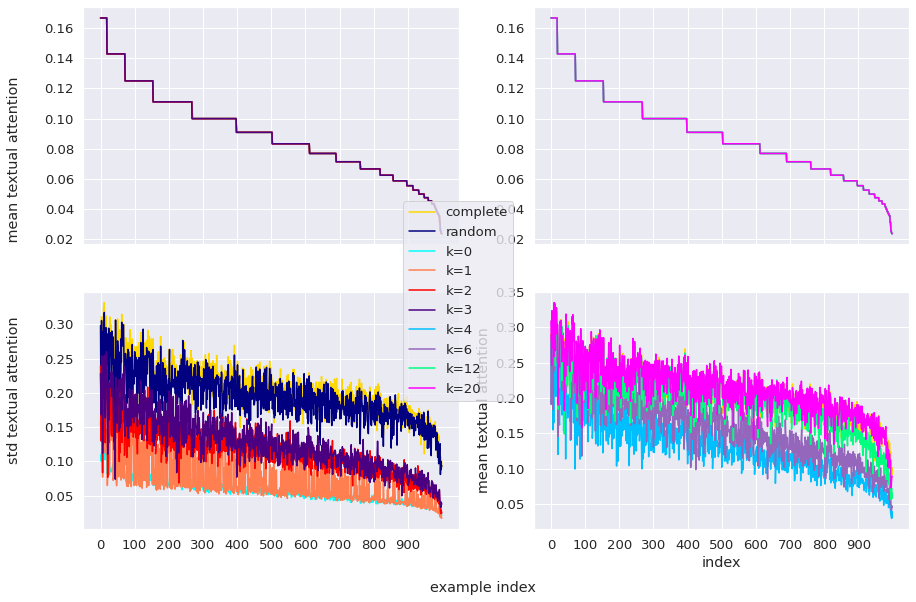

7
0 [(560, 0.83777016), (146, 0.80664545), (795, 0.76395833), (343, 0.7620685), (613, 0.75546694), (211, 0.72295), (229, 0.7219364), (972, 0.7171024), (218, 0.7005852), (788, 0.67899936), (908, 0.67330784), (239, 0.6599751), (655, 0.659076), (995, 0.65388256), (449, 0.640765)]
1 [(9, 0.89200467), (709, 0.8601473), (851, 0.8545688), (624, 0.8301323), (910, 0.8178871), (329, 0.7827092), (781, 0.77882594), (288, 0.75996757), (602, 0.7493205), (401, 0.7462561), (246, 0.7454075), (512, 0.74461955), (879, 0.7422981), (789, 0.71700805), (56, 0.70505714)]
2 [(183, 0.8563445), (642, 0.76726186), (137, 0.7655828), (757, 0.7511573), (927, 0.7287732), (978, 0.72563934), (910, 0.71800464), (734, 0.71571416), (760, 0.70382905), (624, 0.703292), (391, 0.69536555), (906, 0.6932198), (321, 0.68945426), (709, 0.6871578), (671, 0.6828346)]
3 [(602, 0.9373818), (31, 0.897194), (480, 0.88830453), (924, 0.8766164), (113, 0.85312045), (381, 0.8461156), (203, 0.83915836), (81, 0.80455816), (442, 0.7912282), (

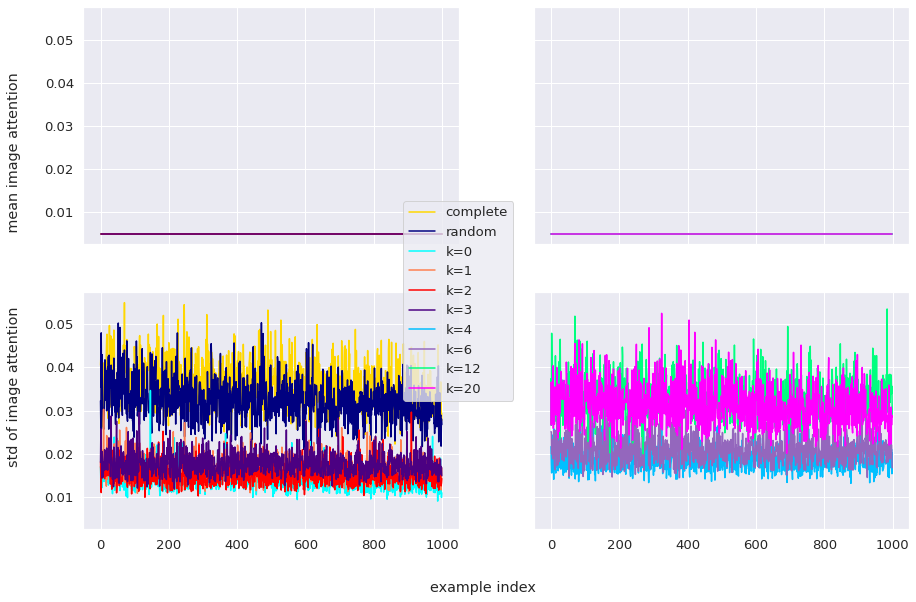

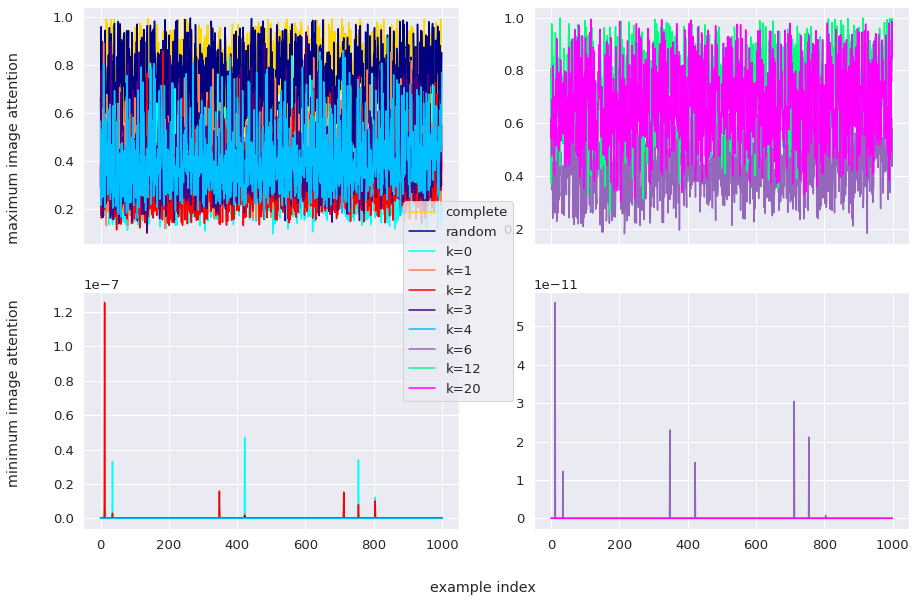

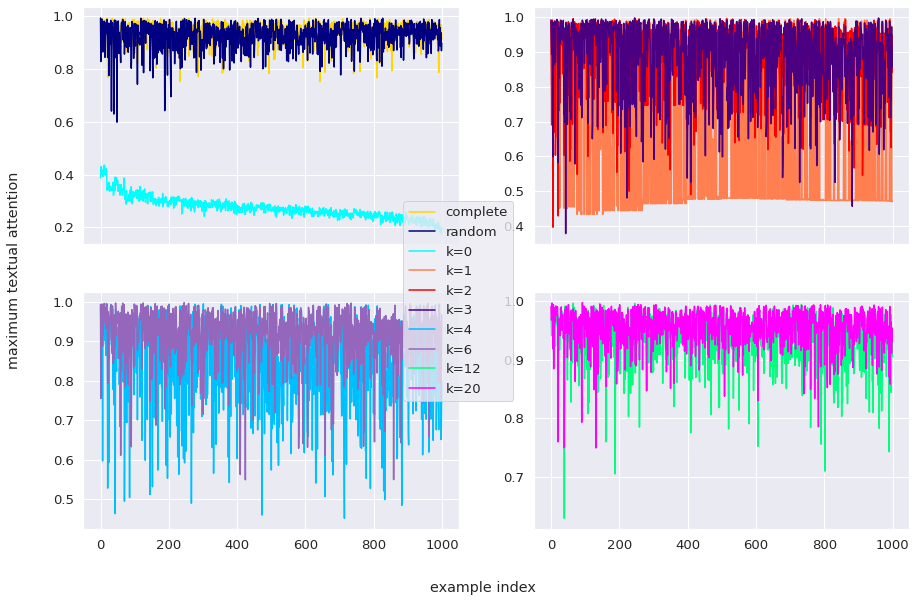

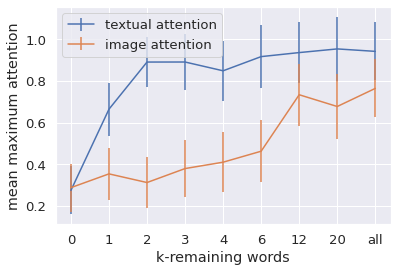

In [7]:
english2gold = get_sentences()
print(len(res4f))
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
ax.set_xticks([i for i in range(0, len(res4f), 100)])
ax2.set_xticks([i for i in range(0, len(res4f), 100)])
ax3.set_xticks([i for i in range(0, len(res4f), 100)])
ax4.set_xticks([i for i in range(0, len(res4f), 100)])
labels = []
ta_means, ta_stds, ia_means_c, ia_stds_c, ia_maxs_c, ia_mins_c, ta_maxs_c = [], [], [], [], [], [], []
for idx in range(len(res4f)):
    ta, ia = plot(m1, res4f, idx, "complete", english2gold, smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_std = ta.std()
    ia_std = ia.std()
    ta_maxs_c.append(ta.max())
    ia_maxs_c.append(ia.max())
    ia_mins_c.append(ia.min())
    ta_means.append(ta_mean)
    ta_stds.append(ta_std)
    ia_means_c.append(ia_mean)
    ia_stds_c.append(ia_std)
    #plt.close("all")
l1, = ax.plot(ta_means, color="gold")
ax3.plot(ta_means, color="gold")
ax2.plot(ta_stds, color="gold")
ax4.plot(ta_stds, color="gold")
labels.append("complete")
ta_means, ta_stds = [], []
ta_means, ta_stds, ia_means_r, ia_stds_r, ia_maxs_r, ia_mins_r, ta_maxs_r = [], [], [], [], [], [], []
for idx in range(len(res4f_random)):
    ta, ia = plot(m2, res4f_random, idx, "random", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_std = ta.std()
    ia_std = ia.std()
    ta_maxs_r.append(ta.max())
    ia_maxs_r.append(ia.max())
    ia_mins_r.append(ia.min())
    ta_means.append(ta_mean)
    ta_stds.append(ta_std)
    ia_means_r.append(ia_mean)
    ia_stds_r.append(ia_std)
    ##plt.close("all")
    #print(idx)
l2, = ax.plot(ta_means, color="navy")
ax2.plot(ta_stds, color="navy")
labels.append("random")
ta_means, ta_stds, ia_means_0, ia_stds_0, ia_maxs_0, ia_mins_0, ta_maxs_0 = [], [], [], [], [], [], []
for idx in range(len(res4f_0_remaining)):
    ta, ia = plot(m3, res4f_0_remaining, idx, "0_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_std = ta.std()
    ia_std = ia.std()
    ia_maxs_0.append(ia.max())
    ia_mins_0.append(ia.min())
    ta_means.append(ta_mean)
    ta_maxs_0.append(ta.max())
    ia_means_0.append(ia_mean)
    ta_stds.append(ta_std)
    ia_stds_0.append(ia_std)
    #plt.close("all")
    #print(idx)
l3, = ax.plot(ta_means, color="aqua")
ax2.plot(ta_stds, color="aqua")
labels.append("k=0")
ta_means, ta_stds, ia_means_1, ia_stds_1, ia_maxs_1, ia_mins_1, ta_maxs_1 = [], [], [], [], [], [], []
for idx in range(len(res4f_1_remaining)):
    ta, ia  = plot(m4, res4f_1_remaining, idx, "1_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ia_std = ia.std()
    ta_std = ta.std()
    ia_maxs_1.append(ia.max())
    ia_mins_1.append(ia.min())
    ta_means.append(ta_mean)
    ta_maxs_1.append(ta.max())
    ia_means_1.append(ia_mean)
    ta_stds.append(ta_std)
    ia_stds_1.append(ia_std)
    #plt.close("all")
    #print(idx)
l4, = ax.plot(ta_means, color="coral")
ax2.plot(ta_stds, color="coral")
labels.append("k=1")
ta_means, ta_stds, ia_means_2, ia_stds_2, ia_maxs_2, ia_mins_2, ta_maxs_2 = [], [], [], [], [], [], []
for idx in range(len(res4f_2_remaining)):
    ta, ia = plot(m5, res4f_2_remaining, idx, "2_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ia_mean = ia.mean()
    ta_maxs_2.append(ta.max())
    ia_std = ia.std()
    ta_std = ta.std()
    ia_maxs_2.append(ia.max())
    ia_mins_2.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_2.append(ia_mean)
    ta_stds.append(ta_std)
    ia_stds_2.append(ia_std)
    #plt.close("all")
    #print(idx)
l5, = ax.plot(ta_means, color="red")
ax2.plot(ta_stds, color="red")
labels.append("k=2")
ta_means, ta_stds, ia_means_3, ia_stds_3, ia_maxs_3, ia_mins_3, ta_maxs_3 = [], [], [], [], [], [], []
for idx in range(len(res4f_3_remaining)):
    ta, ia = plot(m6, res4f_3_remaining, idx, "3_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ia_maxs_3.append(ia.max())
    ia_mins_3.append(ia.min())
    ta_maxs_3.append(ta.max())
    ta_means.append(ta_mean)
    ia_means_3.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_3.append(ia.std())
    #plt.close("all")
    #print(idx)
l6, = ax.plot(ta_means, color="indigo")
ax2.plot(ta_stds, color="indigo")
labels.append("k=3")
ta_means, ta_stds, ia_means_4, ia_stds_4, ia_maxs_4, ia_mins_4, ta_maxs_4 = [], [], [], [], [], [], []
for idx in range(len(res4f_4_remaining)):
    ta, ia =plot(m7, res4f_4_remaining, idx, "4_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ta_maxs_4.append(ta.max())
    ia_maxs_4.append(ia.max())
    ia_mins_4.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_4.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_4.append(ia.std())
    #plt.close("all")
    #print(idx)
l7, = ax3.plot(ta_means, color="deepskyblue")
ax4.plot(ta_stds, color="deepskyblue")
labels.append("k=4")
ta_means, ta_stds, ia_means_6, ia_stds_6, ia_maxs_6, ia_mins_6, ta_maxs_6 = [], [], [], [], [], [], []
for idx in range(len(res4f_6_remaining)):
    ta, ia = plot(m8, res4f_6_remaining, idx, "6_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ia_maxs_6.append(ia.max())
    ta_maxs_6.append(ta.max())
    ia_mins_6.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_6.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_6.append(ia.std())
    #plt.close("all")
    #print(idx)
l8, = ax3.plot(ta_means, color="tab:purple")
ax4.plot(ta_stds, color="tab:purple")
labels.append("k=6")
ta_means, ta_stds, ia_means_12, ia_stds_12, ia_maxs_12, ia_mins_12, ta_maxs_12 = [], [], [], [], [], [], []
for idx in range(len(res4f_12_remaining)):
    ta, ia = plot(m9, res4f_12_remaining, idx, "12_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ia_maxs_12.append(ia.max())
    ta_maxs_12.append(ta.max())
    ia_mins_12.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_12.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_12.append(ia.std())
    #plt.close("all")
    #print(idx)
l9, = ax3.plot(ta_means, color="springgreen")
ax4.plot(ta_stds, color="springgreen")
labels.append("k=12")
ta_means, ta_stds, ia_means_20, ia_stds_20, ia_maxs_20, ia_mins_20, ta_maxs_20 = [], [], [], [], [], [], []
for idx in range(len(res4f_20_remaining)):
    ta, ia = plot(m10, res4f_20_remaining, idx, "20_rem", smooth=True, maxnorm=True, only_mean_std=True)
    ta_mean = ta.mean()
    ta_std = ta.std()
    ta_maxs_20.append(ta.max())
    ia_maxs_20.append(ia.max())
    ia_mins_20.append(ia.min())
    ta_means.append(ta_mean)
    ia_means_20.append(ia.mean())
    ta_stds.append(ta_std)
    ia_stds_20.append(ia.std())
    #plt.close("all")
    #print(idx)
l10, = ax3.plot(ta_means, color="fuchsia")
ax4.plot(ta_stds, color="fuchsia")
labels.append("k=20")
plt.xlabel("index")
plt.ylabel("mean textual attention")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc='center')
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'std textual attention                mean textual attention', ha='center', va='center', rotation='vertical')
plt.show()
# Good samples: 464, 615, 7, 103
idx = np.random.choice(len(res4f), size=1)[0]
idx = 7
english2gold = get_sentences()
print(idx)
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True, sharey=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
l1, = ax.plot(ia_means_c, color="gold")
ax2.plot(ia_stds_c, color="gold")
l2, = ax.plot(ia_means_r, color="navy")
ax2.plot(ia_stds_r, color="navy")
l3, = ax.plot(ia_means_0, color="aqua")
ax2.plot(ia_stds_0, color="aqua")
l4, = ax.plot(ia_means_1, color="coral")
ax2.plot(ia_stds_1, color="coral")
l5, = ax.plot(ia_means_2, color="red")
ax2.plot(ia_stds_2, color="red")
l6, = ax.plot(ia_means_3, color="indigo")
ax2.plot(ia_stds_3, color="indigo")
l7, = ax3.plot(ia_means_4, color="deepskyblue")
ax4.plot(ia_stds_4, color="deepskyblue")
l8, = ax3.plot(ia_means_6, color="tab:purple")
ax4.plot(ia_stds_6, color="tab:purple")
l9, = ax3.plot(ia_means_12, color="springgreen")
ax4.plot(ia_stds_12, color="springgreen")
l10, = ax3.plot(ia_means_20, color="fuchsia")
ax4.plot(ia_stds_20, color="fuchsia")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc="center")
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'std of image attention                mean image attention', ha='center', va='center', rotation='vertical')
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
l1, = ax.plot(ia_maxs_c, color="gold")
ax2.plot(ia_mins_c, color="gold")
l2, = ax.plot(ia_maxs_r, color="navy")
ax2.plot(ia_mins_r, color="navy")
l3, = ax.plot(ia_maxs_0, color="aqua")
ax2.plot(ia_mins_0, color="aqua")
l4, = ax.plot(ia_maxs_1, color="coral")
ax2.plot(ia_mins_1, color="coral")
l5, = ax.plot(ia_maxs_2, color="red")
ax2.plot(ia_mins_2, color="red")
l6, = ax.plot(ia_maxs_3, color="indigo")
ax2.plot(ia_mins_3, color="indigo")
l7, = ax.plot(ia_maxs_4, color="deepskyblue")
ax2.plot(ia_mins_4, color="deepskyblue")
l8, = ax3.plot(ia_maxs_6, color="tab:purple")
ax4.plot(ia_mins_6, color="tab:purple")
l9, = ax3.plot(ia_maxs_12, color="springgreen")
ax4.plot(ia_mins_12, color="springgreen")
l10, = ax3.plot(ia_maxs_20, color="fuchsia")
ax4.plot(ia_mins_20, color="fuchsia")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc="center")
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'minimum image attention            maximum image attention', ha='center', va='center', rotation='vertical')
fig, axes= plt.subplots(2, 2, figsize=(14.8, 9.6),sharex=True)
ax = axes[0, 0]
ax2 = axes[1, 0]
ax3 = axes[0, 1]
ax4 = axes[1, 1]
l1, = ax.plot(ta_maxs_c, color="gold")
l2, = ax.plot(ta_maxs_r, color="navy")
l3, = ax.plot(ta_maxs_0, color="aqua")
l4, = ax3.plot(ta_maxs_1, color="coral")
l5, = ax3.plot(ta_maxs_2, color="red")
l6, = ax3.plot(ta_maxs_3, color="indigo")
l7, = ax2.plot(ta_maxs_4, color="deepskyblue")
l8, = ax2.plot(ta_maxs_6, color="tab:purple")
l9, = ax4.plot(ta_maxs_12, color="springgreen")
l10, = ax4.plot(ta_maxs_20, color="fuchsia")
fig.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8, l9, l10], labels=labels, loc="center")
fig.text(0.5, 0.04, 'example index', ha='center', va='center')
fig.text(0.06, 0.5, 'maximum textual attention', ha='center', va='center', rotation='vertical')

arrays = []
arrays_i = []
arrays_s = []
arrays_si = []
for array in [ta_maxs_0, ta_maxs_1, ta_maxs_2, ta_maxs_3, ta_maxs_4, ta_maxs_6, ta_maxs_12, ta_maxs_20, ta_maxs_c]:
    arrays.append(np.asarray(array).mean())
    arrays_s.append(np.asarray(array).std())
highest_image_attention_indices = {}
k2abl = {1:1, 2:2, 3:3, 4:4, 0:0, 5:6, 6:12, 7:20, 8:"complete", "random":"random"}
for k, array in enumerate([ia_maxs_0, ia_maxs_1, ia_maxs_2, ia_maxs_3, ia_maxs_4, ia_maxs_6, ia_maxs_12, ia_maxs_20, ia_maxs_c]):
    arrays_i.append(np.asarray(array).mean())
    arrays_si.append(np.asarray(array).std())
    a = [(index, array[index]) for index in range(len(array))]
    
    highest_image_attention_indices[k] = sorted(a, reverse=True, key=lambda x: x[1])[0:15]
for key, top in highest_image_attention_indices.items():
    print(key, top)
fig, ax = plt.subplots()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels([0, 1, 2, 3, 4, 6, 12, 20, "all"])
plt.xlabel("k-remaining words")
plt.ylabel("mean maximum attention")
ax.errorbar([i for i in range(9)], arrays, arrays_si, label="textual attention")
ax.errorbar([i for i in range(9)], arrays_i, arrays_si, label="image attention")
plt.legend()
array = [(index,  ia_maxs_r[index]) for index in range(len(ia_maxs_r))]
highest_image_attention_indices["random"] = sorted(a, reverse=True, key=lambda x: x[1])[0:15]

In [11]:
for k, top_a in highest_image_attention_indices.items():
    print(k)
    if isinstance(k, int):
        if k < 9:
            continue
    k = k2abl[k]
    for sample in top_a:
        tas, ias = plot(m1, res4f, sample[0], f"complete_model_{k}", english2gold, smooth=True, maxnorm=True)
        tas, ias = plot(m2, res4f_random, sample[0], f"random_model_{k}", smooth=True, maxnorm=True)
        tas, ias = plot(m3, res4f_0_remaining, sample[0], f"0_rem_model_{k}", smooth=True, maxnorm=True)
        tas, ias = plot(m4, res4f_1_remaining, sample[0], f"1_rem_model_{k}", smooth=True, maxnorm=True)
        tas, ias = plot(m5, res4f_2_remaining, sample[0], f"2_rem_model_{k}", smooth=True, maxnorm=True)
        tas, ias = plot(m6, res4f_3_remaining, sample[0], f"3_rem_model_{k}", smooth=True, maxnorm=True)
        tas, ias = plot(m7, res4f_4_remaining, sample[0], f"4_rem_model_{k}", smooth=True, maxnorm=True)
        tas, ias = plot(m8, res4f_6_remaining, sample[0], f"6_rem_model_{k}", smooth=True, maxnorm=True)
        tas, ias = plot(m10, res4f_20_remaining, sample[0], f"20_rem_model_{k}", smooth=True, maxnorm=True)

0
1
2
3
4
5
6
7
8
random
a woman walking down a street lined with cars in the dark . <eos>
une femme marchant dans une rue bordée de voitures dans l&apos; obscurité .
two baseball players talking on the field <eos>
deux joueurs de baseball discutent sur le terrain
a monster truck flies upside down over a mound of dirt . <eos>
un &quot; monster truck &quot; vole la tête en bas au dessus d&apos; un monticule de terre .
unk makes finding image impossible
several children playing on a court with balls <eos>
plusieurs enfants jouant sur un terrain avec des ballons
two young men wrestling competitively <eos>
deux jeunes hommes luttent compétitivement
seamstress carefully performing her art . <eos>
une couturière faisant soigneusement son métier .
unk makes finding image impossible
a boy is folding paper in the ground <eos>
un garçon plie du papier sur le sol
pink sky on a snowy day has tents on a platform . <eos>
un ciel rose lors d&apos; une journée enneigée avec des tentes sur une platefor

In [ ]:
tas, ias = plot(m2, res4f_random, idx, smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m3, res4f_0_remaining, idx, "0_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m4, res4f_1_remaining, idx, "1_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m5, res4f_2_remaining, idx, "2_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m6, res4f_3_remaining, idx, "3_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m7, res4f_4_remaining, idx, "4_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m8, res4f_6_remaining, idx, "6_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m9, res4f_12_remaining, idx, "12_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m10, res4f_20_remaining, idx, "20_rem", smooth=True, maxnorm=True)

In [ ]:
tas, ias = plot(m1, res4f, idx, english2goldstandard=english2gold, smooth=True, maxnorm=True)
tas, ias = plot(m9, res4f_12_remaining, idx, smooth=True, maxnorm=True)
tas, ias = plot(m3, res4f_0_remaining, idx, smooth=True, maxnorm=True)